### generating then ranking audio
- load the CNN model (or some other ranker) from feature_extraction 
- genereate parameters and its corresponding audio "randomly"
- rank the parameters using the ranker
- save the parameters that made the sound along with the rankings to some dataframe

In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
from feature_extraction import CNN_utils
import matplotlib.pyplot as plt
import librosa
# generation imports
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import helpers as hp

import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
from feature_extraction import mir_utils as mu
###
import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
###
import scipy.stats as ss
sr=44100
stack_size=3
BATCH_SIZE=1
classes=['clap', 'guitar',
         'hat', 'kick', 'noise',
         'piano', 'rim', 'shake', 'snare', 'synth','tom', 'voc']
classes_ranked=[c+"_rank" for c in classes]
cDict={v:i for i,v in enumerate(classes)}

# function to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"
s=torch.load("feature_extraction/models/model-4-18.states")
cnn = CNN_utils.CNN_net()
cnn.load_state_dict(s["model_state_dict"])
cnn.to(device)
pass

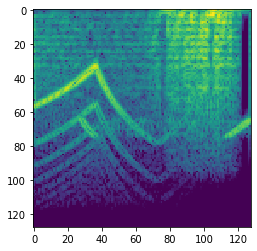

In [4]:
# example of how to make an audio stack, get audio, make (mel_spectrum) image for that audio
out,params=hp.stackMaker(stack_size)
a=hp.memToAud(out)
# get the image for that audio
im=mu.audToImage(a,128)
im=librosa.util.normalize(im)
plt.imshow(im)
# Audio(a,rate=sr, autoplay=True)

In [23]:
%%time
import imp
imp.reload(pg)
imp.reload(hp)

def t(a):
    im=mu.audToImage(a,128)
    z=librosa.util.normalize(im)
    t= transforms.Compose(
        [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    #normalize array->pilform ->apply transoforms,
    z=(((z - z.min()) / (z.max() - z.min())) * 255.9).astype(np.uint8)
    zi=Image.fromarray(z)
    z=t(zi)
    return z
# make a row of data and show what's going on
def makeRowSlow():
    ## function that makes a row of parameters and the scores for the parameters 
    ## this row can then be added to a dataframe/csv file etc
    out,params=hp.stackMaker(1)
    a=hp.memToAud(out)
    # get the image for that audio
    z=t(a)
    images=z.reshape([1,1,128,128])
    dimg=images.to(device)
    outputs=cnn(dimg)
    _, predicted = torch.max(outputs, 1)
    o=outputs.cpu().detach().numpy()[0]
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    score_dict=dict(zip(classes,o_norm))
    #ranks based on score
    ranks=1+len(classes_ranked)-ss.rankdata(o_norm) 
    rank_dict=dict(zip(classes_ranked,ranks))
    df=pd.concat([pd.DataFrame.from_dict([rank_dict]),pd.DataFrame.from_dict([score_dict]),hp.paramToDF(params)],axis=1) 
    
    imshow(torchvision.utils.make_grid(images))
    print(sorted(score_dict.items(), key=lambda x: x[1],reverse=True))

    return a,score_dict,params,df,z
a,score_dict,params,df,image=makeRowSlow()

Audio(a,rate=sr, autoplay=True)

CPU times: user 137 ms, sys: 77.6 ms, total: 215 ms
Wall time: 51.3 ms


#### here's what a row looks like, next print rows like this without the headers so we can redirect it to a csv/text file

In [6]:
df.columns

Index(['clap_rank', 'guitar_rank', 'hat_rank', 'kick_rank', 'noise_rank',
       'piano_rank', 'rim_rank', 'shake_rank', 'snare_rank', 'synth_rank',
       'tom_rank', 'voc_rank', 'clap', 'guitar', 'hat', 'kick', 'noise',
       'piano', 'rim', 'shake', 'snare', 'synth', 'tom', 'voc', 'oscType_0',
       'isNoise_0', 'A_0', 'D_0', 'S_0', 'R_0', 'pitch_0_0', 'pitch_1_0',
       'pitch_2_0', 'pitch_3_0', 'amplitude_0', 'bpCutLow_0', 'bpCutHigh_0',
       'bpOrder_0', 'length_0', 'start_0'],
      dtype='object')

In [7]:
# make a lot of rows, this can be run as its own script if you want to do multi-processing
for i in range(10):
    ## function that makes a row of parameters and the scores for the parameters 
    ## this row can then be added to a dataframe/csv file etc
    out,params=hp.stackMaker(1)
    a=hp.memToAud(out)
    # get the image for that audio
    try:
        im=mu.audToImage(a,128)
    except:
        pass
    z=librosa.util.normalize(im)
    t= transforms.Compose(
        [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    #normalize array->pilform ->apply transoforms,
    z=(((z - z.min()) / (z.max() - z.min())) * 255.9).astype(np.uint8)
    zi=Image.fromarray(z)
    z=t(zi)
    images=z.reshape([1,1,128,128])

    dimg=images.to(device)
    outputs=cnn(dimg)
    _, predicted = torch.max(outputs, 1)

    o=outputs.cpu().detach().numpy()[0]
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    score_dict=dict(zip(classes,o_norm))
    #ranks based on score
    ranks=1+len(classes_ranked)-ss.rankdata(o_norm) 
    rank_dict=dict(zip(classes_ranked,ranks))
    df=pd.concat([pd.DataFrame.from_dict([rank_dict]),pd.DataFrame.from_dict([score_dict]),hp.paramToDF(params)],axis=1)    
    x=df.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
    vals = [','.join(ele.split()) for ele in x]
    
    with open ("test.txt","a") as t:
        t.write(vals[0]+"\n")